In [1]:
import torch 
import torchvision
import torch.nn as nn
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.decomposition import TruncatedSVD
from cut_sentence import segment

In [29]:
content = pd.read_csv('./movie_comments.csv', encoding='utf-8')
content = content.dropna(axis=0,how='any')
print(len(content),content)

130454             id                                        link  \
0            1  https://movie.douban.com/subject/26363254/   
1            2  https://movie.douban.com/subject/26363254/   
2            3  https://movie.douban.com/subject/26363254/   
3            4  https://movie.douban.com/subject/26363254/   
4            5  https://movie.douban.com/subject/26363254/   
5            6  https://movie.douban.com/subject/26363254/   
6            7  https://movie.douban.com/subject/26363254/   
7            8  https://movie.douban.com/subject/26363254/   
8            9  https://movie.douban.com/subject/26363254/   
9           10  https://movie.douban.com/subject/26363254/   
10          11  https://movie.douban.com/subject/26363254/   
11          12  https://movie.douban.com/subject/26363254/   
12          13  https://movie.douban.com/subject/26363254/   
13          14  https://movie.douban.com/subject/26363254/   
14          15  https://movie.douban.com/subject/26363254/   
1

In [3]:
model = Word2Vec.load("wiki.model")
word_vectors = model.wv
del model

In [4]:
import random
#1. 预处理---分词
data=[]
for item in content.iterrows():
#     print(item[1]['comment'])
    words = segment(item[1]['comment'],type='arr')
#     print(words)
    data.append({'comment':item[1]['comment'],'star':item[1]['star'],'words':words})

#2. 预处理---分解为训练集/验证集/测试集
total_size = len(data)
print(len(data))
train_size = int(0.7*total_size)
print(train_size)
valid_size = int(0.2*total_size)
test_size = int(0.1*total_size)
print("use train_size: %d, valid_size: %d, test_size: %d" % (train_size,valid_size,test_size))

random.shuffle(data)
train_set = data[:train_size]
valid_set = data[train_size:train_size+valid_size]
test_set = data[(train_size+valid_size):train_size+valid_size+test_size]

# def sentence_embedding(sentence,vocabulary):
#     pass

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\webberg\AppData\Local\Temp\jieba.cache
Loading model cost 0.821 seconds.
Prefix dict has been built succesfully.


130454
91317
use train_size: 91317, valid_size: 26090, test_size: 13045


In [5]:
from collections import defaultdict
# 尝试采用SIF sentence embedding(https://www.colern.com/paper/get?paperid=1bcb3f85-45ba-4f21-9609-4a598eb32cec)

def get_sentence_embedding(dataset):
    # 1.计算词频
    # unigram probability
    p_w=defaultdict(int)
    train_words_count  = 0

    for item in dataset:
        for word in item['words']:
            p_w[word]+=1
            train_words_count += 1
    
    # 初始句向量
    sentence_vectors=[]
    alpha = 0.001
    for sentence in dataset:
        sentence_len = len(sentence['words'])
    #     print(sentence_len)
    #         continue
    #     print(sentence['words'])
        sentence_vec=np.zeros(128)
        for word in sentence['words']:
            if word in word_vectors.vocab:
                sentence_vec += word_vectors[word]*(alpha/(alpha+p_w[word]/train_words_count))
            # 抛弃UNK词,看看效果

        if sentence_len==0:
            print(sentence['comment'])
            sentence_vectors.append(None)
        else:
            sentence_vectors.append(sentence_vec/sentence_len)
            
    # 剔除表情文字及其他长度为0的句子
    new_data_set = pd.DataFrame({'sentence':sentence_vectors,'star':[item['star'] for item in dataset]})
#     print(new_data_set.shape)
    new_data_set = new_data_set.dropna(axis=0,how='any')
#     print(new_data_set.shape)
    
    svd = TruncatedSVD(n_components=1,n_iter=5,random_state=0)
    #将所有求得的初始句向量做成矩阵
    print(new_data_set.shape[0],new_data_set.shape[1])
    sentence_x = np.zeros((new_data_set.shape[0],len(sentence_vectors[0])))
    for i in range(new_data_set.shape[0]):
        sentence_x[i,:]=new_data_set['sentence'].iloc[i]
#     print(sentence_x)
    svd.fit(sentence_x)
    pc = svd.components_
    #计算每个句子的句向量
    embed = sentence_x-sentence_x.dot(pc.transpose()) * pc
#     print(embed.shape)
    return embed,new_data_set

In [6]:
#计算每个句子的句向量
embed,new_train_set = get_sentence_embedding(train_set)
print(embed.shape)

homage homage! the tri-duel scene is a milestone in cinema. Spaghetti Western!!!!
The time live to die.
Luke H cries over this
why quite diff. from the novel?
We do we have to do, so we can do we want to do.
！
RIP Aaliyah
Sean Bean!!!
2012.07.19
Blablablablablablablablablabla
cowboy
User Rating: 8.5/10 (134,315 votes) 
Top 250: #49
funny thing is a french movie influenced by hollywood
T-Bag...
kkw
= =  T-T
Farewell,My Lovely.
You have a dream, you got to protect it.
no friend,all enemy
007
Take it !!!
9.5/10
City of Blinding Lights.
old dogs' carnival
http://movie.douban.com/review/7752434/
a poorly conceived story and a thoroughly unbelievable final act...
hakulamatata
Simon Pegg
2012-8
06.8.14
the worst storyline, the worst music, the worst editing, the worst acting. a bunch of WTF.
crap
8023
THE ONLY LIMIT IS YOURSELF
9.
Framed. Abandoned. Hunted.
X  93008
7.5
Jackie Chan/Jet Li Project
3.7
i n 55!w !
I love the split-screen, James is a hot piece of Dean!
5/10
bitch!
GQMF!KARL URBAN

2008 3 22
x
http://so.youku.com/search_video/q_%E9%AC%BC%E5%AD%90%E6%9D%A5%E4%BA%86
「The things I did, the things I've seen, it becomes who you are. You can't just go home and scrub it off. The only way I could protect you was to walk away. Forget about you and your mom. I wanted a better life for you than the one I chose for myself.」
HAOKAN
warm
with chou dan
2017.7.26 17:06
GREAT!
let it go～
·········NC
A piece of shit
"i know i'm awake but i feel like i'm in a dream."
2012.1.12 0:20
★VCD
how exciting ！！！
so warming
Child In Time
I really don't like Jack Nicholson.
。。。
。。。
dirty, rich and famous stuffs
hen pang
181
Different but not less.
2003.10.17 vcd 303
long time ago...
not bad
anne
philosophy issues
！！1
http://v.youku.com/v_show/id_XMzcyMzUzNzI=.html
Our deepest fear is not that we are inadequate. Our deepest fear is that we are powerful beyond measure.
heartwarming
。。。。。。
Brilliant!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
……
soso
soso
for Rachel Nichols
5 stars, without any doubts.
h

what a cute couple!!
a  long  conversation
“Knowing what you've got,comma; knowing what you need,comma; knowing what you can do without,dash."
Brilliant!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
eva
cool!
Only one thing can make a soul complete, and that thing is love.
boring！！！！！！！！！
run ,oscar
lovely story
……
i like when he is singing with a cigarette
someone was born 4 the stage or the arena
jason statham's movie
I'm not a fan of Santoshi Kon, but he's worth to be seen. Though there are many plot holes Paprika has it's great moments.
Only the cast could be remembered,nothing else````
http://v.youku.com/v_show/id_XMzI3NTM2MA==.html
Nothing is impossible.
It's a love story that I won't forget.
I'm a licensed pilot, took karate in Tokyo. I lectured on economics at Yale. I can memorize the front pages of New York Times in five minutes and repeat it back to U in five weeks. I was the National Golden Gloves champion three years in a row. I'm fluent in four languages and ca
Tree!!!!
this is actua

this is africa
worse than first shot.
-It had to be the top floor,right?
-It's the best!
Are you there wwwwwwww
；）
DVD
UP IN THE AIR，ME TOO
「I'm the first person to be alone on an entire planet.」
charm little film, watching lovely people on screen is so fun. competent direction is also a plus, but it's time to Reitman to step up
Another manly movie! Russell Crowe is a real hero.
MBA course case - Leadership: coorditation and role definition
-Who is the judge?
-The judge is God.
2009-02-15.7
boring````
Touching
2009-12-1 11:31:12 7/6.0(409)
summer
FUCK YOU BACK
x
for Monica Bellucci
I'm not a fan of Santoshi Kon, but he's worth to be seen. Though there are many plot holes Paprika has it's great moments.
noddle soup
2017.2.23 18:24
2003.8.20
4 stars for Johnny..
2007.12.15
This movie is so beautifully crafted. I was enthralled. @IU Cinema
249
Views of Paris seen from a typical foreigners (or for foreigners) point of view. Some stories are good, some not.
OVA
NICOLAS CAGE
a crazy movie
on

No one can be trusted
tell truth.
Not everything is as it seems.


What a classic!!!
chuck berry!!!!
3.5
3.5
cool
homage homage! the tri-duel scene is a milestone in cinema. Spaghetti Western!!!!
A story between a tough guy and a cute little girl~
1987
2007.5.1 cctv6
Tomorrow is another day
p
2008.2.3
x
：（
2013.6.28
KUSO
How can the same thing happen to the same guy twice?
Bradley Cooper❤
x
......
。。。
based on a true story
Petit Nicholas, chouette Nicolas
Fuck，Siniang，ni jiu bu neng fang guo zhong guo dian ying ma !!!
..
http://www.tudou.com/programs/view/Lu4PJfIu0Og
wt the fuck movie!awesome!
To make each day count.
http://v.youku.com/v_playlist/f1682340o1p26.html
http://v.youku.com/v_show/id_XODc1NTY=.html
2001
9.0
so so
8.2；will the lost souls be forgot?
□Gay □Straight ☑ Freshly turned by Emily Blunt
extraordinarily excellent！！
····
@ mk2 bibliothèque
Are you enjoying the time of Eve?
06.08.18
2.21
awesome
NB
memory...
4.5
foot massage！
I'll miss you
A cheesy action movie...
love an

.
magnet:?xt=urn:btih:d6b6d9084ddc8542b188f6681d1c085f51dfb7e1&dn=John.Wick.Chapter.2.2017.1080p.BluRay.x264-SPARKS[rarbg]
panzer vor!!!
AMAZING
reprise
wow··········
excellent!
CCTV6
i'm not your vampire
The best thing you can do is to find somebody who loves you for exactly what you are, good mood, bad mood; beautiful, ugly.
3.4
I would rather have had one breath of her hair,one kiss of her mouth,one touch of her hand than an eternity without it.
cap pas cap？
"Dad died and shes happy because shes gonna dance."OMG
Views of Paris seen from a typical foreigners (or for foreigners) point of view. Some stories are good, some not.
When there is something between you and the people or the things you love, whatever it is, do not let it win.
3.5
8.0/7.2
6.1
........
really suck
hope can set you free～
19
The King's Speech (2010)
http://www.imdb.com/title/tt1504320
http://img3.douban.com/lpic/s4566148.jpg
EL PYS CONGROO
★★★★
I went to the woods because I wanted to live deliberately, I wanted to

Where'd you go?I miss you so~~~
like a cup of hot coco, like a piece of candy, like enjoying a little bitter with a little sweet
= =
oh i like Sonny.
I love kevin spacey
fucking cool
GAINAX
love's lost and found  got and gone
PG retards
This is fucking AMAZING!
Fight for living   Fight for family   Fight for love   Fight for everyone
Be There or Be Square
Angelababy~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5/10
a little better than first one
p
11.6
Oh,lord。
Stand Alone Complex....
So so..
111
fight for your brother, who are next to you
😱
moonriver
a case to end all cases.
Politics, all politics. Great screenplay.
just for Stantham in BLACK suits.
Visual effect FTW!
Shutter.Island.2010.BDRip.XviD-iMBT
Logan Lerman
Jack Black's eyebrows really were scary! haha~
r u watching closely?
Tony Jaa~
better than 2
“Luke, I am your father." :D
13
girl, you'll be a woman soon
2008-9-6
Your father was not an exceptional man！
The men who laid off my dad flew all the way from London to HK. Now I wonder how their

★★★★☆
3.5
2007.12.30
wanna and gonna
Forsan et haec olim meminisse iuvabit。
Jude Law
★
J Lo................................
badass
If you are big on visuals, styles and details. This  is definately the one to watch. But storyline is still a long way away from Sin City.
in this shit life...
I don't care what the others say. I am a sucker of the Wachowskis.
faint
T-T
tomorrow the sun will rise,who knows what the tide could bring.
I'm trying to think of a movie that has more F word than this one, despite anything Robert De Niro was in, I don't know, Alpha Dog?
http://movie.douban.com/review/4291588/
KUSOのゴールデンエイジ！
hakunamatata
Love actually is all around
Life is more than a box of chocolate.
http://v.youku.com/v_show/id_XMjIzMTk0MTAw.html
117
2007.7.7
“good,but not that good”
I know someone, later turned to be my people.
http://movie.douban.com/review/4291637/
7.0/7.2
2008 9 13
……
hana，alice。
Beneath this mask there is more than flesh,beneath this mask there is an idea,and ideas are bulle

In [7]:
print(train_set[5])
#查看句向量在词向量空间中的临近词
word_vectors.similar_by_vector(embed[5])

{'comment': '还可以，爆米花电影有点夸张有点搞笑！', 'star': '3', 'words': ['还', '可以', '爆米花', '电影', '有点', '夸张', '有点', '搞笑']}


[('阴谋', 0.5422348380088806),
 ('领导权', 0.5279268026351929),
 ('妄图', 0.5210728049278259),
 ('打倒', 0.5178570747375488),
 ('失败', 0.5106574296951294),
 ('顽固派', 0.5039722323417664),
 ('既得利益', 0.5035663843154907),
 ('反叛者', 0.4924752414226532),
 ('野心家', 0.4890460968017578),
 ('夺权', 0.48900577425956726)]

#### 开始构建神经网络

In [7]:
X = torch.tensor(embed,dtype=torch.float32,requires_grad=True)
print(X.dtype)
y = torch.tensor(new_train_set['star'].values.astype(int)-1,dtype=torch.long)
print(torch.max(y),torch.min(y))
print(y.dtype)
print(len(X),len(y))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
input_size = 128
hidden_size = 1024
num_classes = 5
learning_rate = 0.001

torch.float32
tensor(4) tensor(0)
torch.int64
88806 88806
cuda


In [48]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_size, 2048)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(2048, 4096)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.6)
        self.fc4 = nn.Linear(4096, 2048)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.dropout3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.dropout4(out)
        out = self.fc5(out)
        return out

In [53]:
epoch_size = 201
batch_size = 512
total_step = int(len(y)/batch_size)

model = NeuralNet(input_size, hidden_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=0.0002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=50,gamma=0.1)

losses = []
for epoch in range(epoch_size):
    start = 0
    end = 0
    for i in range(total_step):
        start = end
        end = start + batch_size
        
        labels = y[start:end].to(device)
        inputs = X[start:end].to(device)
        
        outputs = model(inputs)
#         print(outputs.shape)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
#         scheduler.zero_grad()
        loss.backward()
        optimizer.step()
#         scheduler.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, epoch_size, i+1, total_step, loss.item()))
            losses.append(loss.item())
            

Epoch [1/201], Step [100/173], Loss: 1.4049
Epoch [2/201], Step [100/173], Loss: 1.3637
Epoch [3/201], Step [100/173], Loss: 1.3490
Epoch [4/201], Step [100/173], Loss: 1.3168
Epoch [5/201], Step [100/173], Loss: 1.3212
Epoch [6/201], Step [100/173], Loss: 1.3193
Epoch [7/201], Step [100/173], Loss: 1.2985
Epoch [8/201], Step [100/173], Loss: 1.2863
Epoch [9/201], Step [100/173], Loss: 1.2700
Epoch [10/201], Step [100/173], Loss: 1.2544
Epoch [11/201], Step [100/173], Loss: 1.2870
Epoch [12/201], Step [100/173], Loss: 1.2440
Epoch [13/201], Step [100/173], Loss: 1.2670
Epoch [14/201], Step [100/173], Loss: 1.2351
Epoch [15/201], Step [100/173], Loss: 1.2137
Epoch [16/201], Step [100/173], Loss: 1.2201
Epoch [17/201], Step [100/173], Loss: 1.2358
Epoch [18/201], Step [100/173], Loss: 1.2162
Epoch [19/201], Step [100/173], Loss: 1.2296
Epoch [20/201], Step [100/173], Loss: 1.2277
Epoch [21/201], Step [100/173], Loss: 1.2220
Epoch [22/201], Step [100/173], Loss: 1.1926
Epoch [23/201], Ste

Epoch [182/201], Step [100/173], Loss: 0.9629
Epoch [183/201], Step [100/173], Loss: 0.9350
Epoch [184/201], Step [100/173], Loss: 0.9575
Epoch [185/201], Step [100/173], Loss: 0.9160
Epoch [186/201], Step [100/173], Loss: 1.0039
Epoch [187/201], Step [100/173], Loss: 0.9594
Epoch [188/201], Step [100/173], Loss: 0.9782
Epoch [189/201], Step [100/173], Loss: 0.9175
Epoch [190/201], Step [100/173], Loss: 0.9305
Epoch [191/201], Step [100/173], Loss: 0.9735
Epoch [192/201], Step [100/173], Loss: 0.9542
Epoch [193/201], Step [100/173], Loss: 0.9789
Epoch [194/201], Step [100/173], Loss: 0.9478
Epoch [195/201], Step [100/173], Loss: 0.9388
Epoch [196/201], Step [100/173], Loss: 0.9553
Epoch [197/201], Step [100/173], Loss: 0.9453
Epoch [198/201], Step [100/173], Loss: 0.8848
Epoch [199/201], Step [100/173], Loss: 0.9630
Epoch [200/201], Step [100/173], Loss: 0.9036
Epoch [201/201], Step [100/173], Loss: 0.9246


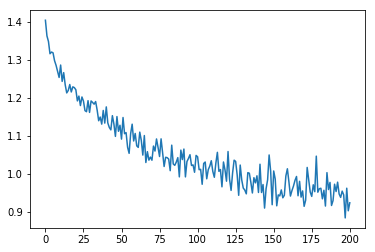

In [54]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [23]:
def display_accuracy(inputs,labels,model):
    with torch.no_grad():
        correct = 0
        total = 0
        y = labels.to(device)
        output = model(inputs.to(device))
        _, predicted = torch.max(output, 1)
        total = y.size(0)
        correct = (predicted == y).sum().item()
        print('Accuracy: {} %'.format(100 * correct / total))

In [55]:
display_accuracy(X,y,model)

Accuracy: 61.57016417809607 %


In [14]:
# 验证集
valid_embed,new_valid_set = get_sentence_embedding(valid_set)        
print(len(valid_embed),len(new_valid_set))
valid_X = torch.tensor(valid_embed,dtype=torch.float32)
valid_labels = torch.tensor(new_valid_set['star'].values.astype(int)-1,dtype=torch.long)

marvelous！
。。
I like singing in rain!
2.11human beings are a disease.
Panzer Vor！
cool...
06.8.15
love  actually
8.2/8.1
http://www.angryalien.com/0406/reservoirbuns.asp
hahahahahahahahahaahahahahahah
Here at the wall.
Can't get it..Sorry!
……
do what we want to do, fuck the rest.
there is miracle only in movie.
7.0/7.7
。。
You are not alone
http://ca224.blog.sohu.com/74786195.html
TOUGHABLE!
I LOVE YOU READ..
PLEASE READ [THE LADY WITH LITTLE DOG]
like a rock
Miners!!
NICE
this fails to make perfect sense to me
Don't forget.Always,somewhere,someone is fighting for you.—As long as you remember her,you are not alone
………………
20101121 jtl
I won't say a goddamn word.They won't understand.They won't understand why we do it. They won't understand it's about the man next to you. And this's it. That's all it is
？
anti-climax
7.4
blahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahblahbl

Kim:Hold me...    Howard:No...
so so
but interesting.
I'll miss you
。。。。
This movie is fantastic, and brutal truth
free will
📘「The computer is Mary in the black and white room. The human is when she walks out.」
I watched it long time ago but still remeber most of the story,that's a factor to judge a movie i suppose.
Awesome movie, recommend to all.
wonderful Mulholland，where the road Lennon live
A promising future...
5555
T850。
no sacrifices,no freedom.........
The B can also be
4.5.
CINEMATHEQUE  220208
awesome
Why do we fall,sir?So that we can learn to pick ourselves up.
2002.2.21
Breaking free。
e3786i89
2008-1-31 7/7.2(472)
moonriver
boring…
No one can be trusted
run run run
2003.3.15 cctv6
http://www.verycd.com/files/97db28f635ac65285bac7790ca7a36ca2234679201
just like a shit
keep running keep killing
2012-09-02
I chose not to choose life. There are no reasons.
good trick
Rambooo
California dreaming
may be 4 times
2009.03.28
Luckey
14/11/2003 12:00pm Ua Shatin
This is government
bl

final
……………………
Cool..
2.28
。。
HOTNESS
！！！！！！！！！！！！！！！！！！！！！！！！！！
I only want to love you.
o captain！my  captain ！
seize the day
NOT BAD
3.5
7.5
Blake Lively
1000 1000000！！
touching story  amazing acting
！！！！
.
Every day I come by to pick you up, and we go out drinkin' or whatever and we have a few laughs. But you know what the best part of my day i
201707221230
City of Blinding Lights.
8.1
にまび
2008-9-6
★★★★☆
x
old dogs' carnival
3.5
2007-11-13 18:02:09 7/6.7(1190)
2008-9-18 16:51:01 7/6.7(1311) cool
obsession
mtv..
better than 1 episode
own and to be owned
。。。。。
Lindsay Lohan
Loki Loki
O__O "…
2.0
8.4/10
BB8
╮(╯▽╰)╭
Every child is special.
Moon River & Tiffany
fuck all the movies
I def will get a sports car!
spirit river?
~~
*cough* HOMO *cough*
"We appear and we disappear, and we're important to some, but we're just passing through. "
080121
2007.9.2 Meg Ryan is appetizing,New York is romantic,Love is smooth, the world is such a warm place
amazingly funny
love & fate
I am Groot, I am 

In [56]:
# 验证集准确率
display_accuracy(valid_X,valid_labels,model)

Accuracy: 40.00947530498638 %


In [58]:
#测试集准确率
test_embed,new_test_set = get_sentence_embedding(test_set)
test_X = torch.tensor(test_embed,dtype=torch.float32)
test_labels = torch.tensor(new_test_set['star'].values.astype(int)-1,dtype=torch.long)

the way we are
culture confliction
。。。。。。。。。。。。。。
x
Dear PJ, you never cease to surprise us; you never disappoint us, either.
Rudy,don't i know you,
inner peace.
11.4
7.0/7.0
bd-Gamma
My forever Angle
3.5
2007-11-5
with kg
20120906
what a great movie..
。。。
2001
+_+
PRETTY WOMAN
8.0
life is like a box of chocolate.
Benjamin..
Cool guy never look back
。。。
8
Julia rocks!Kiki is so cute~
5 stars, without any doubts.
3.5
wtf！！！！！！！
Depp。。~
the voice of Justice...
the sound of Racial Equality...really GREAT !
He won!
http://www.tudou.com/programs/view/_C5U7IYauFM
it's about  how to build a life
Julie is still bangable.
TT。。。
2012.10.28 19:35
armchannel
2
sb
Because you saw me when I was invisible
x
don't remember much about it...
What the difference betwen winner and loser...You will find it...and anything more...
comment
TOM'S DAUGHTER : BUT...
  TOM : JANE!
  T_T
Release the baby!
104:24
Liongate's teenager series
WTF
7.5/7.4
Up.In.The.Air.2009.DVDRip.XviD-Larceny
Be seeing you.
2008.2.11


I Love His Long Legs～
Heads up, look in my eyes.Do you hear? listen to the country.7 minutes, 7 minutes，Defense, defense, defense！ This is it!This is our destiny,
- -
[design to work---die to work ]
sosososososososo
Billy Elliot (2000) t7fcfb5ca9
1900
8
ok
like the diaried which we also have and like the lovely gril next door
Mark......
very funny
http://movie.douban.com/review/7540318/
a
HIGH！
2/1
a story more than love.
2006.5.20
god like crazy people
When people say dreams don't come true, tell them about Rudy.
booshit
ccav.
he's so cute
1--1.1--1--2--3
Cliché buddy movie.
http://www.douban.com/review/1006754/
4.5
sorry
FIN
12650 2


In [59]:
display_accuracy(test_X,test_labels,model)

Accuracy: 39.3201581027668 %
